## Animal Classification

In [3]:
# download data online

import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Resuming download from 265289728 bytes (348797574 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/alessiocorrado99/animals10?dataset_version_number=2 (265289728/614087302) bytes left.


100%|██████████| 586M/586M [06:10<00:00, 942kB/s] 

Extracting files...


Path to dataset files: C:\Users\Omen\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2


I'm overwhelmed, no cap. The dataset is huge.

so first I decided to download the dataset locally but it's like 580 MB which isn't really suitable to push on github. I played around with data locally and then changed the code so now it's more appropriate 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
import pathlib

data_dir = pathlib.Path(path + '\\raw-img')
print(data_dir)

C:\Users\Omen\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


In [12]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

24209


So there are 24209 images

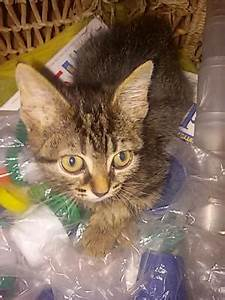

In [22]:
import PIL.Image

cane = list(data_dir.glob('cane/*'))
PIL.Image.open(str(cane[55]))

doggy🐶

well, the author didn't lie when he wrote 'All the images have been collected from "google images" and have been checked by human. There is some erroneous data to simulate real conditions (eg. images taken by users of your app).'

what concerns me is not that though but the fact that some images contain more than one animal of the same species. 

In [37]:
from glob import glob

dir_paths = glob(data_dir.__str__() + '/*')
paths = []

for directory in dir_paths:
    paths.extend(glob('{}/*'.format(directory)))
    
print(f"there are {len(paths)} images")

there are 26179 images


In [45]:
from PIL import Image
import random

for path in random.sample(paths, 10):
    img = Image.open(path)
    print(img.size)

(300, 221)
(300, 240)
(300, 200)
(288, 300)
(300, 164)
(300, 225)
(300, 258)
(300, 195)
(300, 225)
(300, 201)


tf says we need image sizes but they're different. I saw one guy one Kaggle put an average size. Gotta research if that's wrong later.

In [46]:
avg_width = 0
avg_height = 0

for path in paths:
    img = Image.open(path)
    
    avg_width += img.size[0]
    avg_height += img.size[1]
avg_width = avg_width // len(paths)
avg_height = avg_height // len(paths)

In [47]:
avg_width, avg_height

(320, 252)

#### creating a dataset

tbh, I have little to know practical knowledge of both LLM and CV. I'm trying though

In [48]:
batch_size = 96
img_height = avg_height
img_width = avg_width

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.35,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 26179 files belonging to 10 classes.
Using 17017 files for training.


In [50]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.35,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 26179 files belonging to 10 classes.
Using 9162 files for validation.


In [51]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


tf docs note: "Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data"

1) Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
2) Dataset.prefetch overlaps data preprocessing and model execution while training

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### standardize the data

In [53]:
normalization_layer = layers.Rescaling(1./255)

this layer'll be included in the model (tf: "which can simplify deployment")

In [54]:
num_classes = len(class_names)

In [55]:
data_augmentation = keras.Sequential([
  layers.RandomFlip(
    "horizontal",
    input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

In [65]:
model = tf.keras.models.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [66]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [67]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 252, 320, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 252, 320, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 252, 320, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 126, 160, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 126, 160, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 80, 16)       0         
 g2D)                                                 

In [68]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
178/178 [==============================] - 589s 3s/step - loss: 1.9830 - accuracy: 0.2986 - val_loss: 1.7381 - val_accuracy: 0.4102
Epoch 2/10
178/178 [==============================] - 518s 3s/step - loss: 1.5957 - accuracy: 0.4527 - val_loss: 1.5811 - val_accuracy: 0.4693
Epoch 3/10
178/178 [==============================] - 509s 3s/step - loss: 1.3911 - accuracy: 0.5286 - val_loss: 1.4084 - val_accuracy: 0.5266
Epoch 4/10
178/178 [==============================] - 499s 3s/step - loss: 1.2736 - accuracy: 0.5720 - val_loss: 1.3169 - val_accuracy: 0.5614
Epoch 5/10
178/178 [==============================] - 482s 3s/step - loss: 1.1840 - accuracy: 0.6042 - val_loss: 1.2223 - val_accuracy: 0.5874
Epoch 6/10
178/178 [==============================] - 477s 3s/step - loss: 1.1147 - accuracy: 0.6265 - val_loss: 1.1713 - val_accuracy: 0.6078
Epoch 7/10
178/178 [==============================] - 541s 3s/step - loss: 1.0638 - accuracy: 0.6398 - val_loss: 1.1620 - val_accuracy: 0.6095

In [69]:
loss, acc = model.evaluate(val_ds)

print(f"Test Accuracy: {acc * 100:.2f}%")

96/96 [==============================] - 51s 534ms/step - loss: 1.1041 - accuracy: 0.6287
Test Accuracy: 62.87%


In [74]:
# this one is to test on my own images

new_img_path = pathlib.Path('../data/animals_test_img/cat.jpeg')

img = tf.keras.utils.load_img(
    new_img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

most_prob = most_probable(score, 3)
print(f"on pic there {'is' if len(most_prob) == 1 else 'are'}\n\t{''.join([f'{n} {s}%, ' for n, s in most_prob])}")

1/1 [==============================] - 0s 433ms/step
on pic there are
	pecora 20%, ragno 18%, gallina 13%, 


In [72]:
# score = score.numpy()
def most_probable(score, num_of_units = 2) -> list:
  score = score.numpy()
  ranks = [(n, int(s * 100)) for n, s in zip(class_names, score)]
  ranks.sort(key=lambda x: x[1], reverse=True)
  return ranks[:num_of_units]

well, it guessed it ws a kitty on a pic. So I guess it's good enough for now. Obviously not enough to be called good but smth like baseline model or something

In [75]:
# Save the entire model as a `.keras` zip archive.
model.save('../models/classification_model.keras')

In [76]:
new_model = tf.keras.models.load_model('../models/classification_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 252, 320, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 252, 320, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 252, 320, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 126, 160, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 126, 160, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 80, 16)       0         
 g2D)                                                 

In [77]:
predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 83ms/step
This image most likely belongs to pecora with a 20.79 percent confidence.
